# Value at Risk - Risk Management Exploration

This quick project is to do a deep dive on Value at Risk (VaR), a risk management tool that helps investors understand the potential losses their investments might face over a given time frame, with a certain level of confidence.

In [85]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, skew
import QuantLib as ql
import datetime

data = yf.download('NVDA')

data_df = pd.DataFrame(data)

[*********************100%%**********************]  1 of 1 completed


## Method 1 - Historic

Let's calculate the VaR based on historical price movements and returns

### Calculating the Returns

We first need to calculate the returns on our historic data. This is the first step in the Historic Method for finding the Value at Risk.

In [86]:
data_df['Returns'] = data_df['Close'].pct_change()

### Plotting the Returns

Let's plot the Returns to get a visual as to the historic trends and find the Min and Max returns and dates. 

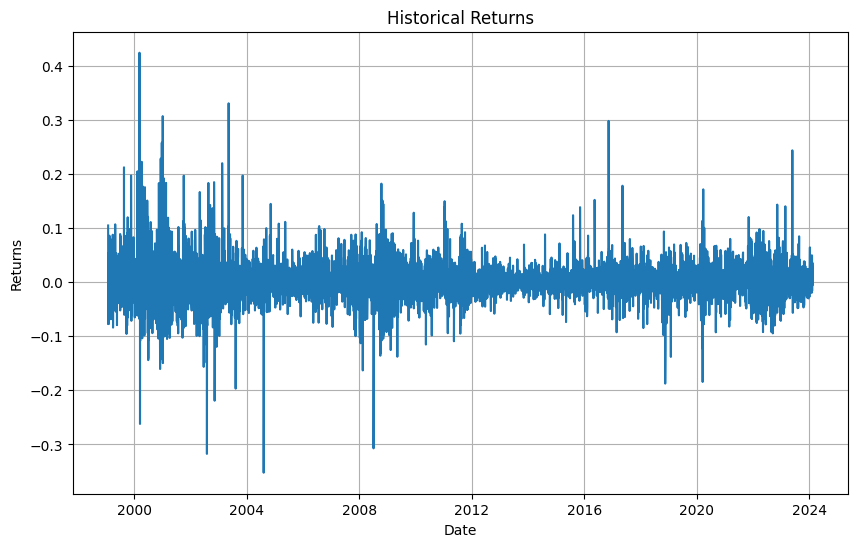

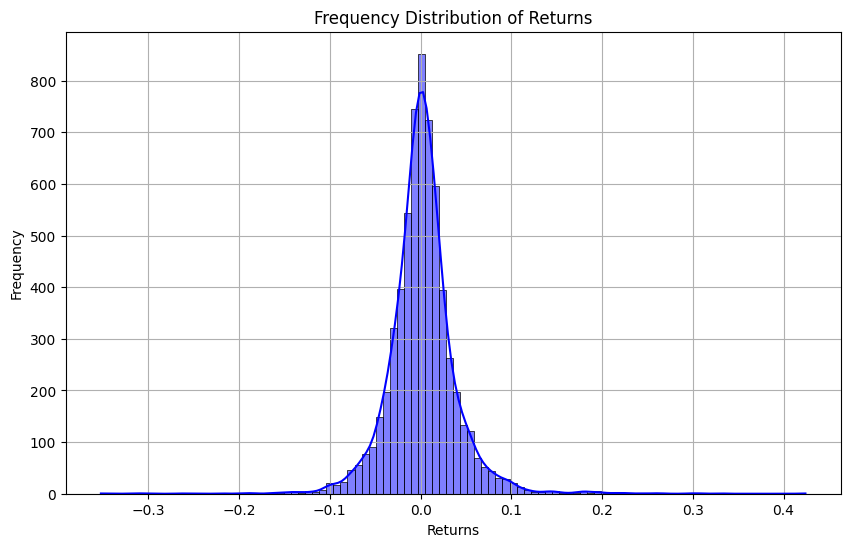

Minimum return: -35.2335266391077 on 2004-08-06 00:00:00
Maximum return: 42.41452339367988 on 2000-03-07 00:00:00
Average return: 0.0018985977991552026


In [95]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data_df['Returns'])
plt.title('Historical Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)
plt.show()

min_return_date = data_df.idxmin()['Returns']
max_return_date = data_df.idxmax()['Returns']

plt.figure(figsize=(10, 6))
sns.histplot(data=data_df['Returns'], bins=100, kde=True, color='blue', edgecolor='black')
plt.title('Frequency Distribution of Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("Minimum return:", data_df['Returns'].min() * 100, "on", min_return_date)
print("Maximum return:", data_df['Returns'].max() * 100, "on", max_return_date)
print("Average return:", data_df['Returns'].mean() * 100)

### Ordering the Returns

Next we order the returns from Largest Loss to Largest Gain (worst to best)

In [88]:
data_df_sorted = data_df.sort_values(by=['Returns'])
print(data_df_sorted)

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2004-08-06   0.842500   0.850000   0.775000   0.785833   0.720880  508894800   
2002-07-31   0.985000   1.005000   0.911667   0.922500   0.846251  483714000   
2008-07-03   3.245000   3.282500   3.100000   3.122500   2.864410  298752000   
2000-03-14   3.092448   3.092448   2.250000   2.294271   2.104638  156777600   
2002-11-08   1.025000   1.085833   0.917500   0.946667   0.868421  379890000   
...               ...        ...        ...        ...        ...        ...   
2016-11-11  19.877501  22.192499  19.625000  21.992500  21.644091  217534400   
2001-01-03   1.208333   1.643229   1.177083   1.630208   1.495463   91036800   
2003-05-09   1.569167   1.794167   1.525000   1.780833   1.633639  923085600   
2000-03-07   1.562500   1.817708   1.494792   1.735677   1.592215  195220800   
1999-01-22   0.437500   0.488281   0.388

### Calculating the Value at Risk

In [89]:
confidence_95 = 0.95
confidence_99 = 0.99

var_index_95 = int(len(data_df_sorted) * (1 - confidence_95))
var_index_99 = int(len(data_df_sorted) * (1 - confidence_99))

VaR_95 = data_df.iloc[var_index_95]['Returns']
VaR_99 = data_df.iloc[var_index_99]['Returns']

print("VaR at", confidence_95*100, "% confidence level:", VaR_95)
print("VaR at", confidence_99*100, "% confidence level:", VaR_99)

VaR at 95.0 % confidence level: -0.00539674100485521
VaR at 99.0 % confidence level: -0.048275461457545354


### Summary of Historic Method

The negative values indicate potential losses, whereas positive values indicate potential gains

In [90]:
print("95% confidence that there are potential", "gains" if VaR_95 > 0 else "losses", "of approximately", '{:.2f}'.format(VaR_95*100), "% of the asset's value")
print("99% confidence that there are potential", "gains" if VaR_99 > 0 else "losses", "of approximately", '{:.2f}'.format(VaR_99*100), "% of the asset's value")

95% confidence that there are potential losses of approximately -0.54 % of the asset's value
99% confidence that there are potential losses of approximately -4.83 % of the asset's value


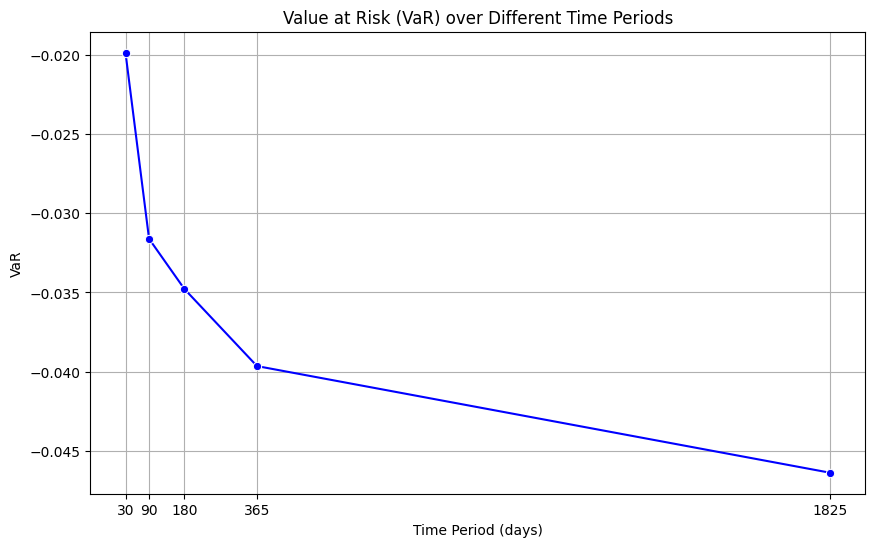

   Time Period (days)    VaR
0                  30  -1.99
1                  90  -3.16
2                 180  -3.48
3                 365  -3.96
4                1825  -4.64


In [91]:
time_periods = [30, 90, 180, 365, 5*365]  # 1 month, 3 months, 6 months, 1 year, 5 years

VaR_values = []

for period in time_periods:
    historic_data_period = data_df.iloc[-period:]  # Subset data for the specified time period
    sorted_returns = historic_data_period['Returns'].sort_values()
    var_index_95 = int(len(sorted_returns) * (1 - confidence_95))
    VaR = sorted_returns.iloc[var_index_95]
    VaR_values.append(VaR)

plt.figure(figsize=(10, 6))
sns.lineplot(x=time_periods, y=VaR_values, marker='o', color='blue')
plt.title('Value at Risk (VaR) over Different Time Periods')
plt.xlabel('Time Period (days)')
plt.ylabel('VaR')
plt.grid(True)
plt.xticks(time_periods)
plt.show()

var_data = pd.DataFrame({'Time Period (days)': time_periods, 'VaR': map(lambda x: '{:.2f}'.format(x*100), VaR_values)})
print(var_data)

## Method 2 - Parametric

Under the assumption that our returns are Normally distributed, we can calculate the VaR using the Mean, Standard Deviation, and Z-Score for a 95% confidence interval.

### Calculate the Mean (Expected return) and Standard Deviation (Volatility)

In [92]:
parametric_mean = np.mean(data_df['Returns'])
parametric_std = np.std(data_df['Returns'])

### Determine the Z-Score and find the VaR

We'll now determine the Z-score based on our 95% confidence interval 

In [93]:
z_score_95 = 1.96
VaR_95 = parametric_mean + z_score_95 * parametric_std
print("95% confidence that there are potential", "gains" if VaR_95 > 0 else "losses", "of approximately", '{:.2f}'.format(VaR_95*100), "% of the asset's value")

95% confidence that there are potential gains of approximately 7.62 % of the asset's value


### Plot of Distribution

Let's plot the distribution and see if it truely is Normal. If not, we will get unexpected results from this method

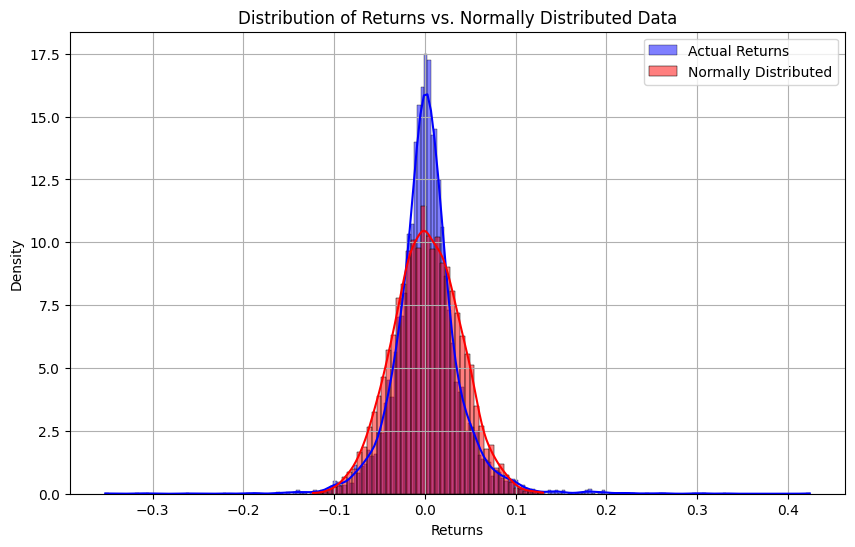

The distribution appears right-skewed (positively skewed).


In [94]:
normal_data = np.random.normal(parametric_mean, parametric_std, len(data_df['Returns']))

plt.figure(figsize=(10, 6))
sns.histplot(data_df['Returns'], kde=True, color='blue', label='Actual Returns', stat='density')
sns.histplot(normal_data, kde=True, color='red', label='Normally Distributed', stat='density')
plt.title('Distribution of Returns vs. Normally Distributed Data')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

returns_list = list(data_df['Returns'])
returns_list = [x for x in returns_list if x == x]

parametric_skewness = skew(returns_list)

if parametric_skewness < -0.5:
    print("The distribution appears left-skewed (negatively skewed).")
elif parametric_skewness > 0.5:
    print("The distribution appears right-skewed (positively skewed).")
else:
    print("The distribution appears approximately symmetric (skewness close to zero).")

### Summary of Parametric

Our results seem counterintuitive to the idea of Value at Risk. VaR is a measure of potential losses thus should be negative. However, using this parametric method shows that the statistical model has a 95% confidence that there are potential _gains_. 

This discrepency between the Historic approach and this are likely due to the assumption that the returns are Normally distributed among other factors such as skewness, kurtosis, etc.

## Summary

Value at Risk (VaR) is a statistical measure used to quantify the potential loss in value of a portfolio or asset over a specified time period, at a certain confidence level. It provides insights into the downside risk of an investment or portfolio.

### Historic Method

- Estimates the VaR based on historic returns
- It ranks the historic returns and calculates the VaR based on observed percentile of historic losses
- Does not rely on distributional assumptions and instead captures market behaviour directly

### Parametric Method

- Estimates the VaR using the assumption of Normal Distribution
- It uses the Drift (Average of historic returns) and Volatility (Standard deviation of historic returns)
- While easy to implement, the Parametric method assumes that returns follow a specific distribution, which may not always be accurate

### Usefulness of VaR

- It provides a single measure of the potential risk
- It quantifyies downside risk of an investment
- It is widely used in the world of finance and investment
- It is a good metric to help investors make informed decisions

### Downfalls of VaR

- Parametric method requires an assumption of Normal Distribution, which may not always be the case
- Historic data may not be the best at capturing times of high volatility, news and political events that have impacted the price of a stock
- Sensitive based on the confidence level that is manually chosen
- VaR does not account for tail risk effectively